In [1]:
import os
os.chdir('..')
from notebooks import config
import torch
import numpy as np
import scipy.ndimage
from utils.geotif_io import readTiff, writeTiff
from utils.imgShow import imgShow,imsShow
from utils.imgPatch import imgPatch
import matplotlib.pyplot as plt
from model.seg_model.model_scales_gate import unet_scales_gate


In [2]:
# ----------- Device --------------- #
device = torch.device('cuda:0')


In [3]:
def img2patchin(img, scales = [256, 512, 2048], overlay=60):
    ratio_mid, ratio_high = scales[1]//scales[0], scales[2]//scales[0],
    imgPat_ins = imgPatch(img=img, patch_size=scales[0], edge_overlay = overlay)
    patch_low_list = imgPat_ins.toPatch()
    patch_mid_list = imgPat_ins.higher_patch_crop(higher_patch_size=scales[1])
    patch_high_list = imgPat_ins.higher_patch_crop(higher_patch_size=scales[2])
    '''Resize multi-scale patches to the same size'''
    patch_mid2low_list = [scipy.ndimage.zoom(input=patch, zoom=(1/ratio_mid, \
                                            1/ratio_mid, 1), order=0) for patch in patch_mid_list]
    patch_high2low_list = [scipy.ndimage.zoom(input=patch, zoom=(1/ratio_high, \
                                            1/ratio_high, 1), order=0) for patch in patch_high_list]
    return patch_low_list, patch_mid2low_list, patch_high2low_list, imgPat_ins


def model_pred(model, inputs):
    '''----Obtain the prediction patches----'''
    pred_patch_list = []
    for idx in range(len(inputs)):
        in_data = [inp.to(device) for inp in inputs[idx]]
        with torch.no_grad():
            pred_patch = model(in_data)      ### for multi-scale patch
            if isinstance(pred_patch,tuple):
                pred_patch = pred_patch[0]
        pred_patch = pred_patch.cpu()   # convert from gpu to cpu
        pred_patch_list.append(pred_patch)
    return pred_patch_list

def swatnet_infer(s1_img, model):
    
    ''' des: surface water mapping by using pretrained watnet
        arg:
            img: np.array, sentinel-1 backscattering values(!!data value: 0-1): ; 
                 consist of 4 band (sascending VV, VH and descending VV, Vh)
            model: the loaded pytorched model.
        retrun:
            water_map: np.array.
    '''

    ### ---- 1. Convert remote sensing image to multi-scale patches ----
    print('convert image to multi-scale pathes input...')
    patch_low_list, patch_mid_list, patch_high_list, imgPat_ins = \
                            img2patchin(s1_img, scales = [256, 512, 2048], overlay=60)

    ## formating data from 3d to 4d torch.tensor
    patch_high_list_ = [torch.from_numpy(patch.transpose(2,0,1)[np.newaxis,:]).float() \
                                                                    for patch in patch_high_list]
    patch_mid_list_ = [torch.from_numpy(patch.transpose(2,0,1)[np.newaxis,:]).float() \
                                                                    for patch in patch_mid_list]
    patch_low_list_ = [torch.from_numpy(patch.transpose(2,0,1)[np.newaxis,:]).float() \
                                                                    for patch in patch_low_list]
    inputs = tuple(zip(patch_high_list_, patch_mid_list_, patch_low_list_)) 
    print('number of multi-scale patches:', len(inputs))

    ### ---- 2. prediction by pretrained model -----
    print('surface water mapping using swatnet model...')
    pred_patch_list = model_pred(model=model, inputs=inputs)

    ### ---- 3. Convert the patches to image ----
    print('comvert patch result to image result...')
    pred_patch_list = [np.squeeze(patch, axis = 0).permute(1, 2, 0) for patch in pred_patch_list]
    pro_map = imgPat_ins.toImage(pred_patch_list)
    wat_map = np.where(pro_map>0.5, 1, 0)

    return wat_map


In [4]:
import glob
path_s1as = '/home/yons/Desktop/developer-luo/Monthly-Surface-Water-in-Tibet/data/tibet_tiles/s1_ascend'
path_s1des = '/home/yons/Desktop/developer-luo/Monthly-Surface-Water-in-Tibet/data/tibet_tiles/s1_descend'
ifile_as = glob.glob(path_s1as + '/*')
ifile_des = glob.glob(path_s1des + '/*')

### obtain pair-wise ascending/descending files.
io_files = []
dir_wat = '/'.join(ifile_as[0].split('/')[:-2]) + '/s1_water'

for i_as in ifile_as:
    for i_des in ifile_des:
        if i_as.split('/')[-1].split('_')[-1] == i_des.split('/')[-1].split('_')[-1]:
            if not os.path.exists(dir_wat):
                os.makedirs(dir_wat)
            name_wat = i_as.split('/')[-1].split('.')[0] + '_water.tif'
            name_wat = name_wat.replace('s1as', 's1')
            o_water = dir_wat + '/' + name_wat
            io_files.append((i_as, i_des, o_water))   
            # print(dir_wat)     
        else:
            continue
print(io_files[0])


('/home/yons/Desktop/developer-luo/Monthly-Surface-Water-in-Tibet/data/tibet_tiles/s1_ascend/tibet_s1as_202008_tile_1.tif', '/home/yons/Desktop/developer-luo/Monthly-Surface-Water-in-Tibet/data/tibet_tiles/s1_descend/tibet_s1des_202008_tile_1.tif', '/home/yons/Desktop/developer-luo/Monthly-Surface-Water-in-Tibet/data/tibet_tiles/s1_water/tibet_s1_202008_tile_1_water.tif')


In [5]:
'''Model loading'''
model_name= 'model_scales_gate'
path_model_weights = config.root + '/model/pretrained/'+ model_name +'_weights.pth'
# model = unet_scales(num_bands=4, num_classes=2, \
#                         scale_high=2048, scale_mid=512, scale_low=256)
model = unet_scales_gate(num_bands=4, num_classes=2, \
                        scale_high=2048, scale_mid=512, scale_low=256)
model.load_state_dict(torch.load(path_model_weights))
model.to(device)    # load on gpu
model = model.eval()
type(model)


model.seg_model.model_scales_gate.unet_scales_gate

In [6]:
for i in range(len(io_files)):

    ### ---- 1. preprocessing
    ### ---- 1.1 data reading
    print('data reading...')
    print(io_files[i][0])
    print(io_files[i][1])
    s1_ascend, s1_ascend_info = readTiff(path_in = io_files[i][0])
    s1_descend, _ = readTiff(path_in = io_files[i][1])
    s1_img = np.concatenate((s1_ascend, s1_descend), axis=2)
    print('image shape:', s1_img.shape)

    ### ---- 1.2. image normalization ----
    print('data normalization...')
    s1_img_nor = s1_img.copy()
    for j in range(s1_img.shape[-1]):
        s1_img_nor[:,:,j] = (s1_img[:,:,j] - config.s1_min[j])/(config.s1_max[j]-config.s1_min[j]+0.0001)

    ### ---- 2. surface water mapping ----
    print('surface water mapping using swatnet model...')
    wat_map = swatnet_infer(s1_img=s1_img_nor, model=model)

    ### ---- 3. write out the water map -----
    print('write out the result image...')
    writeTiff(im_data = wat_map.astype(np.int8), 
                im_geotrans = s1_ascend_info['geotrans'], 
                im_geosrs = s1_ascend_info['geosrs'], 
                path_out = io_files[i][2])
    print('write out -->')
    print(io_files[i][2])


data reading...
/home/yons/Desktop/developer-luo/Monthly-Surface-Water-in-Tibet/data/tibet_tiles/s1_ascend/tibet_s1as_202008_tile_1.tif
/home/yons/Desktop/developer-luo/Monthly-Surface-Water-in-Tibet/data/tibet_tiles/s1_descend/tibet_s1des_202008_tile_1.tif
image shape: (12139, 13332, 4)
data normalization...
surface water mapping using swatnet model...
convert image to multi-scale pathes input...
number of multi-scale patches: 4278
surface water mapping using swatnet model...
comvert patch result to image result...
write out the result image...
write out -->
/home/yons/Desktop/developer-luo/Monthly-Surface-Water-in-Tibet/data/tibet_tiles/s1_water/tibet_s1_202008_tile_1_water.tif
data reading...
/home/yons/Desktop/developer-luo/Monthly-Surface-Water-in-Tibet/data/tibet_tiles/s1_ascend/tibet_s1as_202008_tile_3.tif
/home/yons/Desktop/developer-luo/Monthly-Surface-Water-in-Tibet/data/tibet_tiles/s1_descend/tibet_s1des_202008_tile_3.tif
image shape: (11982, 13504, 4)
data normalization...


### Visualize the final classification map

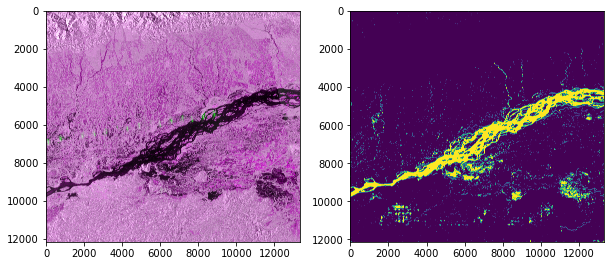

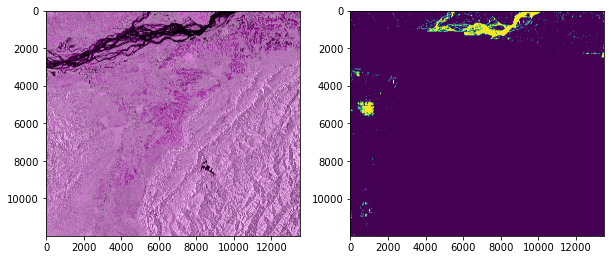

In [7]:
for i in range(len(io_files)):
    ### ---- 1. data reading
    s1_ascend, _ = readTiff(path_in = io_files[i][0])
    s1_water, _ = readTiff(path_in = io_files[i][2])
    ### ---- 2. show the image and result
    plt.figure(figsize=(10,6))
    plt.subplot(1,2,1)
    imgShow(s1_ascend, clip_percent=2, color_bands=(0,1,0))
    plt.subplot(1,2,2)
    plt.imshow(s1_water)
